In [1]:
import json
from pathlib import Path
import datetime
import codecs
import copy

from sklearn.metrics import confusion_matrix, roc_auc_score
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd
from scipy.io import wavfile
from scipy import signal

import tensorflow as tf


DATA_PATH = Path('data')

ALLOWED_LABELS = set(["yes", "no", "up", "down", "left", "right", "on", "off", "stop", 
                      "go", "zero", "one", "two", "three", "four",
                      "five", "six", "seven", "eight", "nine"])

SAMPLE_RATE = 16000


def get_info_row(x):
    """Splits one row int path, label and user_id"""
    path = x.split('\n')[0]
    label = transform_label(path.split('/')[0])
    user_id = path.split('/')[1].split('_')[0]
    return path, label, user_id

def transform_label(label):
    if label not in ALLOWED_LABELS:
        label = 'unknown'
    return label

def load_test_data_info(data_path):
    """Returns list of tuples in format (path, label, user_id)"""
    with open(data_path / "validation_list.txt", "r") as f:
        validation_list = [x for x in f.readlines()]
    with open(data_path / "testing_list.txt", "r") as f:
        testing_list = [x for x in f.readlines()]

    test_info = validation_list + testing_list
    test_info = map(lambda x: get_info_row(x), test_info)
    return list(test_info)

def get_train_test_data_info(data_path):
    """Returns list of tuples in format (path, label, user_id)"""
    test_info = load_test_data_info(data_path)
    
    train_info = []
    paths = set([x[0] for x in test_info])
    for file_path in data_path.glob('*/*.wav'):
        path = str(file_path).split(str(data_path) + '/')[1]
        if path not in paths:
            train_info.append((path,
                               transform_label(path.split('/')[0]),
                               path.split('/')[1].split('_')[0]))

    return train_info, test_info


def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    """Computes log spectogram of a wav sample"""
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.astype(np.float32) + eps)
    
def pad_audio(samples, length=16000):
    """Pads samples that have less than 'length' samples with 0"""
    if len(samples) >= length:
        return samples
    else:
        return np.pad(samples, pad_width=(length - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, length=16000):
    """Chops audio to have 'length' samples"""
    return samples[:length]

def preprocess_data(file_path):
    """Applies transformations to the file (like computing spectrogram)"""
    sample_rate, samples = wavfile.read(file_path)
    samples = pad_audio(samples)
    samples = chop_audio(samples)
    
    _, _, spectrogram = log_specgram(samples, sample_rate)
    return spectrogram.T

def get_plot_confusion_matrix(cmatrix):
    """Plots confusion matrix heatmap"""
    df_cm = pd.DataFrame(cmatrix, index = list(label_to_index.keys()),
                  columns = list(label_to_index.keys()))
    fig = plt.figure(figsize = (16, 9))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    return fig

def get_summary(probs, true_labels):
    """Returns dict with accuracy, confusion matrix plot, binary probabilities per class and AUC per class"""
    pred_labels = np.argmax(probs, axis=1)
    accuracy = sum(pred_labels == true_labels) / len(test_labels)
    print(f"accuracy: {accuracy}")
    cmatrix = confusion_matrix(true_labels, pred_labels)
    plot = get_plot_confusion_matrix(cmatrix)
    index_to_label = {v: k for k, v in label_to_index.items()}
    
    aucs = []
    classes_probs = []
    classes_true_labels = []
    for class_label in label_to_index.values():
        class_label_verbose = index_to_label[class_label]
        
        class_true_labels = np.where(np.squeeze(true_labels) == class_label, 1, 0)
        class_probs = probs[:, class_label]
        classes_probs.append(class_probs)
        classes_true_labels.append(class_true_labels)
        
        auc = roc_auc_score(class_true_labels, class_probs)
        aucs.append(auc)
        print(f"class {class_label_verbose} AUC: {auc}")
        
    return {"accuracy": accuracy, "AUC_per_class": aucs, "plot": plot,
            "classes_probs": class_probs.tolist(), "class_true_labels": class_true_labels.tolist()}
    

def save_results(model, summary, description, results_dir="results"):
    """Saves model, summary and plot on a drive"""
    results_path = Path('results')
    date_str = datetime.datetime.now().strftime("%Y%m%dT%H%M")
    folder_name = f"results_{date_str}_{description}"
    results_folder_path = results_path / folder_name
    results_folder_path.mkdir()
    
    summary["plot"].savefig(results_folder_path / "cmatrix.png")
    
    summary_copy = summary.copy()
    summary_copy.pop("plot")
    
    model.save(results_folder_path / 'model.h5') 
    
    with open(results_folder_path / "evaluation.json", "w") as f:
        json.dump(summary_copy, f)
    
    def model_summary_to_file(summary):
        with open(results_folder_path / "model_summary.txt", 'w') as f:
            print(summary, file=f)

    model.summary(print_fn=model_summary_to_file)
    print(f"Results saved in {results_folder_path}")

In [2]:
train_info, test_info = get_train_test_data_info(DATA_PATH)
np.random.shuffle(train_info)

In [3]:
train_paths = [str(DATA_PATH / x[0]) for x in train_info]
train_labels = [x[1] for x in train_info]

test_paths = [str(DATA_PATH / x[0]) for x in test_info]
test_labels = [x[1] for x in test_info]

label_to_index = dict((name, index) for index, name in enumerate(set(train_labels)))

train_labels = [np.array(label_to_index[x]) for x in train_labels]
test_labels = [np.array(label_to_index[x]) for x in test_labels]

def gen_X_train():
    """Returns generator of X_train values"""
    for path in train_paths:
        yield preprocess_data(path)
        
def gen_X_test():
    """Returns generator of X_test values"""
    for path in test_paths:
        yield preprocess_data(path)
        
def gen_y_train():
    """Returns generator of y train values"""
    for label in train_labels:
        yield label
        
def gen_y_test():
    """Returns generator of y test values"""
    for label in test_labels:
        yield label

In [4]:
X_train = tf.data.Dataset.from_generator(gen_X_train, tf.float64)
y_train = tf.data.Dataset.from_generator(gen_y_train, tf.int32)
train_ds = tf.data.Dataset.zip((X_train, y_train))

X_test = tf.data.Dataset.from_generator(gen_X_test, tf.float64)
y_test = tf.data.Dataset.from_generator(gen_y_test, tf.int32)
test_ds = tf.data.Dataset.zip((X_test, y_test))

BATCH_SIZE = 32

W0527 11:17:14.370900 140681388517184 deprecation.py:323] From /home/marcin/git/MGU-lstm/venv/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:410: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.shuffle(buffer_size=500).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [6]:
def lr_schedule(epoch):
    if epoch > 20:
        return 0.00001
    elif epoch > 10:
        return 0.0001
    else:
        return 0.001
    
scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              min_delta=0,
                                              patience=3,
                                              verbose=0, mode='auto')
steps_per_epoch = np.ceil(len(train_labels)/BATCH_SIZE)

W0519 21:01:57.827484 139902022338368 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f3ce45840f0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0519 21:01:57.832149 139902022338368 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f3ce4584668>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 99, 16)            7744      
_________________________________________________________________
batch_normalization_v2 (Batc (None, 99, 16)            64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 99, 32)            1568      
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 99, 32)            128       
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 21)                2709      
Total params: 61,877
Trainable params: 61,781
Non-trainable params: 96
___________________________________________________

/home/marcin/git/MGU-lstm/venv/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


2652/2652 [==============================] - 238s 90ms/step - loss: 1.5640 - accuracy: 0.5195 - val_loss: 0.9233 - val_accuracy: 0.7090
Epoch 2/30
2652/2652 [==============================] - 232s 88ms/step - loss: 0.6528 - accuracy: 0.7964 - val_loss: 0.4930 - val_accuracy: 0.8430
Epoch 3/30
2652/2652 [==============================] - 240s 90ms/step - loss: 0.4479 - accuracy: 0.8598 - val_loss: 0.4168 - val_accuracy: 0.8675
Epoch 4/30
2652/2652 [==============================] - 231s 87ms/step - loss: 0.3524 - accuracy: 0.8888 - val_loss: 0.3233 - val_accuracy: 0.8983
Epoch 5/30
2652/2652 [==============================] - 228s 86ms/step - loss: 0.3012 - accuracy: 0.9048 - val_loss: 0.2897 - val_accuracy: 0.9097
Epoch 6/30
2652/2652 [==============================] - 228s 86ms/step - loss: 0.2616 - accuracy: 0.9175 - val_loss: 0.2845 - val_accuracy: 0.9101
Epoch 7/30
2652/2652 [==============================] - 229s 86ms/step - loss: 0.2378 - accuracy: 0.9242 - val_loss: 0.2550 - val

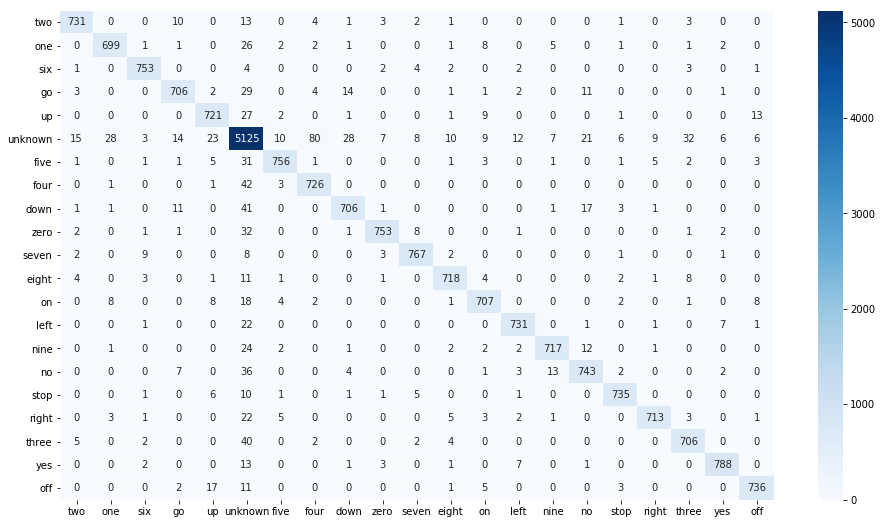

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(input_shape=(99, 161), filters=16, kernel_size=3, activation='selu', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='selu', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(len(ALLOWED_LABELS) + 1, activation=tf.keras.activations.softmax)
])
model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds, epochs=30, steps_per_epoch=steps_per_epoch,
          validation_data=test_ds, callbacks=[scheduler, early_stopping])

preds = model.predict(test_ds)
summary = get_summary(preds, test_labels)
save_results(model, summary, "small-bi")